# Decision-Driven Customer Churn Analysis

**Project 3 of 6 – Data Science & ML Portfolio**

This project focuses on predicting customer churn and translating model insights into
**business decisions** such as retention strategies and revenue protection.

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression

## Dataset Information

- **Dataset:** Telco Customer Churn
- **Source:** IBM / Kaggle
- **Records:** ~7,000 customers
- **Target Variable:** `Churn` (Yes / No)

### Features include:
- Customer demographics
- Subscription services
- Contract & billing details
- Tenure and payment behavior

In [46]:
# Load dataset
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Preview data
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Churn Distribution Analysis

Before building a predictive model, it is important to understand:
- How many customers are churning
- Whether churn is a balanced or imbalanced problem

This helps in selecting appropriate evaluation metrics and modeling strategies.

In [47]:
# Churn distribution
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

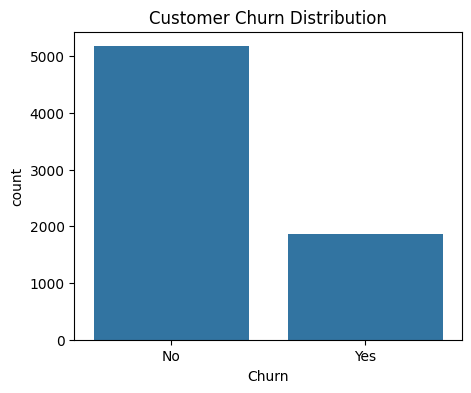

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.countplot(x='Churn', data=df)
plt.title("Customer Churn Distribution")
plt.show()

## Contract Type vs Customer Churn

Customer contract duration plays a crucial role in retention.
In this analysis, we study how churn varies across different contract types:
- Month-to-month
- One year
- Two year

This insight helps businesses design better retention and pricing strategies.

In [49]:
# Churn by contract type
pd.crosstab(df['Contract'], df['Churn'])

Churn,No,Yes
Contract,,
Month-to-month,2220,1655
One year,1307,166
Two year,1647,48


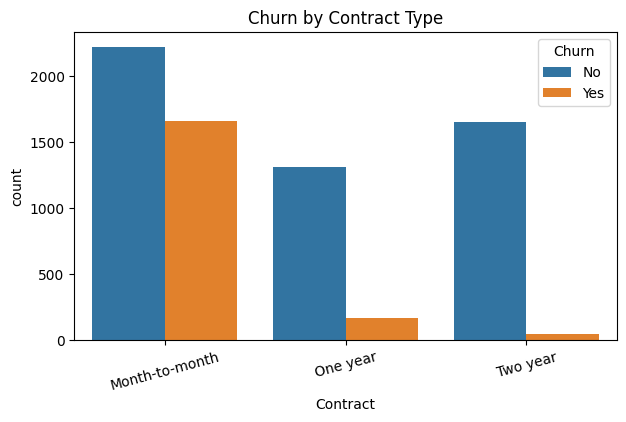

In [50]:
plt.figure(figsize=(7,4))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Churn by Contract Type")
plt.xticks(rotation=15)
plt.show()

## Monthly Charges vs Customer Churn

Pricing is a major factor influencing customer churn.
In this analysis, we examine how monthly charges differ between customers
who churned and those who stayed.

Understanding this helps businesses optimize pricing and retention offers.

In [51]:
# Summary statistics of monthly charges by churn
df.groupby('Churn')['MonthlyCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,61.265124,31.092648,18.25,25.10,64.425,88.4,118.75
Yes,1869.0,74.441332,24.666053,18.85,56.15,79.650,94.2,118.35


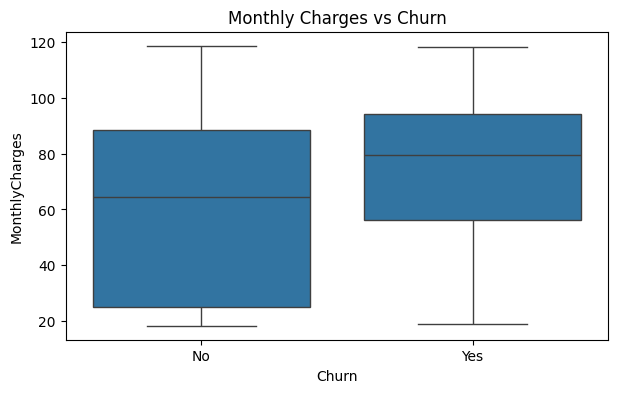

In [52]:
plt.figure(figsize=(7,4))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.title("Monthly Charges vs Churn")
plt.show()

## Customer Tenure vs Churn

Customer tenure reflects how long a customer has stayed with the company.
Longer-tenure customers are generally more loyal, while new customers
are more likely to churn.

This analysis helps identify at-risk customer segments based on tenure.

In [53]:
# Summary statistics of tenure by churn
df.groupby('Churn')['tenure'].describe()

,count,mean,std,min,25%,50%,75%,max
Churn,,,,,,,,
No,5174.0,37.569965,24.113777,0.0,15.0,38.0,61.0,72.0
Yes,1869.0,17.979133,19.531123,1.0,2.0,10.0,29.0,72.0


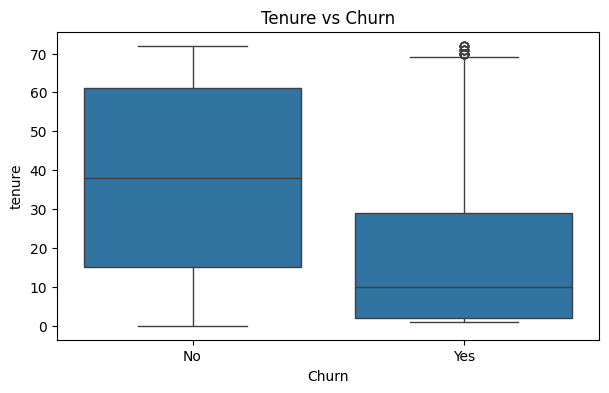

In [54]:
plt.figure(figsize=(7,4))
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title("Tenure vs Churn")
plt.show()

## Data Cleaning and Feature Preparation

Before modeling, we clean the dataset by:
- Fixing incorrect data types
- Handling missing or invalid values
- Preparing features for machine learning models

In [55]:
# Check data types
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [56]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Check missing values
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [57]:
# Drop rows with missing TotalCharges
df = df.dropna()

# Verify
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Feature Encoding and Train-Test Split

Machine learning models require numerical inputs.
We convert categorical variables into numerical form and
prepare the dataset for training and evaluation.

In [63]:
# Encode target variable: Churn (Yes/No -> 1/0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

df['Churn'].value_counts()

Series([], Name: count, dtype: int64)

In [64]:
# Drop customerID
df = df.drop('customerID', axis=1)

# One-hot encode categorical features
df_encoded = pd.get_dummies(df, drop_first=True)

df_encoded.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,NaN,False,True,False,False,True,...,False,False,False,False,False,False,True,False,True,False
1,0,34,56.95,1889.50,NaN,True,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
2,0,2,53.85,108.15,NaN,True,False,False,True,False,...,False,False,False,False,False,False,True,False,False,True
3,0,45,42.30,1840.75,NaN,True,False,False,False,True,...,False,False,False,False,True,False,False,False,False,False
4,0,2,70.70,151.65,NaN,False,False,False,True,False,...,False,False,False,False,False,False,True,False,True,False


In [3]:
# Re-load dataset cleanly
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Drop identifier
df.drop(columns=["customerID"], inplace=True)

# Fix TotalCharges
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Encode Churn ONCE
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Drop missing rows AFTER encoding
df.dropna(inplace=True)

# One-hot encode
df_encoded = pd.get_dummies(df, drop_first=True)

print(df_encoded.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'WA_Fn-UseC_-Telco-Customer-Churn.csv'